# Analyzing global internet patterns

## 1. Background
The idea for this project originated from a Datacamp competition (https://app.datacamp.com/learn/competitions/visualize-internet-usage), where the participants were tasked with:
- cleaning and analyzing the data to identify changes and patterns in internet usage,
- creating a self-explanatory and interactive dashboard using a tool of choice,
- optionally incorporating supplemental data,
- writing an executive summary of the findings.
For my project, I expanded the scope to investigate factors potentially affecting internet penetration, identify regions disconnected from the internet and propose recommendations to improve internet penetration in these areas.

## 2. Data
Participants were given a dataset of countries and their internet penetration for the years 2000 - 2023 (`internet_usage.csv`). The file was sourced from the World Bank Databank website (https://databank.worldbank.org/source/world-development-indicators/Series/IT.NET.USER.ZS#)

I brought in additional data from the following sources:
- https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD - GDP PPP per capita,
- https://hdr.undp.org/data-center/documentation-and-downloads - HDI,
- https://www.itu.int/en/ITU-D/Statistics/Pages/ICTprices/default.aspx - fixed-broadband services cost in PPP,
- https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS - percentage of urban population,
- https://hdr.undp.org/data-center/documentation-and-downloads - Global Inequality Index (GII)
- https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS - percentage of population aged 65 and over,
- https://data.worldbank.org/indicator/SP.POP.TOTL - total population by country,
- https://data.worldbank.org/indicator/AG.LND.TOTL.K2 - total country land area,
- https://datahub.itu.int/data/?i=19303 - number of fixed-broadband subscriptions,
- https://datahub.itu.int/data/?i=11632 - number of mobile-broadband subscriptions,
- https://www.oecd.org/en/data/indicators/population-with-tertiary-education.html - percentage of population aged 25-34 with higher education, 
- https://app.gen5.digital/tracker/metrics - ICT regulatory tracker.

## 3. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Loading data and verifying

The data contains 217 countries with their names, codes and internet penetration numbers for the years 2000-2023. 
- Country name and country code fields contain no null values and no duplicates. 
- The year fields representing internet penetration contain no null values, but some entries contain a placeholder string ".." indicating missing penetration values.
- Year 2023 contains the most missing penetration values (over 70%).

In [2]:
internet_usage = pd.read_csv("../data/internet_usage.csv") 

print("Shape: ", internet_usage.shape)
print("First 5 rows:\n", internet_usage.head())
print("Checking nulls:\n", internet_usage.isna().sum())
print("Checking vals on 2023:\n", internet_usage["2023"].value_counts(dropna="False").head())
print("Checking unique vals:\n", internet_usage.nunique(dropna="True"))

Shape:  (217, 26)
First 5 rows:
      Country Name Country Code      2000        2001       2002       2003  \
0     Afghanistan          AFG        ..  0.00472257  0.0045614  0.0878913   
1         Albania          ALB  0.114097    0.325798   0.390081     0.9719   
2         Algeria          DZA  0.491706    0.646114    1.59164    2.19536   
3  American Samoa          ASM        ..          ..         ..         ..   
4         Andorra          AND   10.5388          ..    11.2605    13.5464   

       2004     2005     2006     2007  ...  2014  2015     2016     2017  \
0  0.105809  1.22415  2.10712      1.9  ...     7  8.26       11     13.5   
1   2.42039  6.04389  9.60999  15.0361  ...  54.3  56.9     59.6     62.4   
2   4.63448  5.84394  7.37598  9.45119  ...  29.5  38.2  42.9455  47.6911   
3        ..       ..       ..       ..  ...    ..    ..       ..       ..   
4    26.838  37.6058  48.9368    70.87  ...  86.1  87.9     89.7  91.5675   

      2018     2019     2020     20

## 3. Data cleanup and feature engineering

Unpivoting the data.

In [3]:
internet_usage_melted = internet_usage.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Internet_Penetration")
print(internet_usage_melted.shape)

(5208, 4)


Bringing in supplemental data from other sources.
1. Economic & development factors
   - GDP per capita (USD, PPP adjusted)
   - Human Development Index (HDI)
   - Cost of Internet
   - Urban Population
   - Percentage of Population with Higher Education among 25-34 yo

In [11]:
# GDP per capita (USD, PPP adjusted)
gdp_ppp = pd.read_csv("../data/GDP_PPP.csv", skiprows=4)
# remove unnecessary columns
gdp_ppp.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], inplace=True)
# unpivot
gdp_ppp = gdp_ppp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP_PPP_per_capita")
print("GDP per capita: \n", gdp_ppp.head(3))

# Human Development Index (HDI)
hdi = pd.read_excel("../data/hdr-data.xlsx", usecols=[0, 1, 7, 8])
# rename column to HDI
hdi.rename(columns={"value": "HDI"}, inplace=True)
print("Human Development Index: \n", hdi.head(3))

# Cost of Internet
coi = pd.read_excel("../data/ITU_ICTPriceBaskets_2008-2023.xlsx", sheet_name="economies_2008-2023")
# Filter for purchasing power parity and fixed broadband basket only
coi = coi[(coi["Unit"] == "PPP") & (coi["basket_combined_simplified"] == "Fixed-broadband basket")]
# remove unnecessary columns
coi.drop(columns=["Code", "LDC", "LLDC", "SIDS", "Income_2023", "Unit", "basket_combined_simplified"], inplace=True)
# unpivot
coi = coi.melt(id_vars=["IsoCode", "Economy", "ITURegion"], var_name="Year", value_name="Cost_PPP")
print("Cost of Internet: \n", coi.head(3))

# Urban Population
urban_pop = pd.read_csv("../data/urban_population.csv", skiprows=4)
# remove unnecessary columns
urban_pop.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], inplace=True)
# unpivot
urban_pop = urban_pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urban_Pop_Pct")
print("Urban population: \n", urban_pop.head(3))

# Percentage of Population with Higher Education among 25-34 yo
pop_high_edu = pd.read_csv("../data/population_higher_education_25-34.csv", usecols=[4, 5, 14, 16])
# rename column
pop_high_edu.rename(columns={"OBS_VALUE": "Pop_High_Edu"}, inplace=True)
print("Population with higher education: \n", pop_high_edu.head(3))

GDP per capita: 
                   Country Name Country Code  Year  GDP_PPP_per_capita
0                        Aruba          ABW  1960                 NaN
1  Africa Eastern and Southern          AFE  1960                 NaN
2                  Afghanistan          AFG  1960                 NaN
Human Development Index: 
   countryIsoCode      country  year    HDI
0            AFG  Afghanistan  1990  0.284
1            AFG  Afghanistan  1991  0.292
2            AFG  Afghanistan  1992  0.299
Cost of Internet: 
   IsoCode      Economy        ITURegion  Year  Cost_PPP
0     ABW        Aruba  Other Economies  2008       NaN
1     AFG  Afghanistan   Asia & Pacific  2008       NaN
2     AGO       Angola           Africa  2008     234.4
Urban population: 
                   Country Name Country Code  Year  Urban_Pop_Pct
0                        Aruba          ABW  1960      50.776000
1  Africa Eastern and Southern          AFE  1960      14.576676
2                  Afghanistan          AFG 

2. Technological & Infrastructure performance Indicators
    - Fixed Internet Subscription Rates
    - Mobile Internet Subscription Rates

In [12]:
# Fixed Internet Subscription Rates
fixed_int = pd.read_csv("../data/fixed-broadband-subscriptions.csv", usecols=[1, 6, 7, 8, 9])
# rename column
fixed_int.rename(columns={"dataValue": "Fixed_Subs"}, inplace=True)
# filter for specific series code
fixed_int = fixed_int[fixed_int["seriesCode"] == "i992b"]
print("Fixed internet subscription rates: \n", fixed_int.head(3))

# Mobile Internet Subscription Rates
mobile_int = pd.read_csv("../data/active-mobile-broadband-subscriptions.csv", usecols=[1, 6, 7, 8, 9])
# rename column
mobile_int.rename(columns={"dataValue": "Mobile_Subs"}, inplace=True)
# filter for specific series code
mobile_int = mobile_int[mobile_int["seriesCode"] == "i911mw"]
print("Mobile internet subscription rates: \n", mobile_int.head(3))

Fixed internet subscription rates: 
      seriesCode entityIso entityName  Fixed_Subs  dataYear
4245      i992b       ABW      Aruba     1.51555      2003
4246      i992b       ABW      Aruba     7.46999      2004
4247      i992b       ABW      Aruba    13.02560      2005
Mobile internet subscription rates: 
      seriesCode entityIso   entityName  Mobile_Subs  dataYear
2948     i911mw       ABW        Aruba       0.0000      2010
2949     i911mw       ABW        Aruba      20.6362      2012
2950     i911mw       AFG  Afghanistan       0.0000      2007


3. Social and cultural aspects
    - Gender Inequality Index

In [13]:
# Gender inequality index
gii = pd.read_excel("../data/GII-data.xlsx", usecols = [0, 1, 7, 8])
# Rename column
gii.rename(columns={"value": "GII"}, inplace=True)
print("Gender Inequality Index: \n", gii.head(3))

Gender Inequality Index: 
   countryIsoCode      country  year    GII
0            AFG  Afghanistan  2008  0.690
1            AFG  Afghanistan  2009  0.696
2            AFG  Afghanistan  2010  0.707


4. Socio-Demographic and Geographical Breakdown
    - Population aged 65 and over
    - Total population
    - Country area
    - Region

In [14]:
# Population aged 65 and over
pop_65_over = pd.read_csv("../data/population_65_and_over.csv", skiprows=4)
# remove unnecessary columns
pop_65_over.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], inplace=True)
# unpivot
pop_65_over = pop_65_over.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Pop_65_and_Over")
print("Population 65yo and over: \n", pop_65_over.head(3))

# Total population
pop_total = pd.read_csv("../data/population_total.csv", skiprows=4)
# remove unnecessary columns
pop_total.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], inplace=True)
# unpivot
pop_total = pop_total.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Pop_Total")
print("Total population: \n", pop_total.head(3))

# Country area
area = pd.read_csv("../data/country_area.csv", skiprows=4)
# remove unnecessary columns
area.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], inplace=True)
# unpivot
area = area.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Land_Area")
print("Land area: \n", area.head(3))

# Region
region = pd.read_excel("../data/UNSD — Methodology.xlsx")
print("Region: \n", region.head(3))

Population 65yo and over: 
                   Country Name Country Code  Year  Pop_65_and_Over
0                        Aruba          ABW  1960         2.855868
1  Africa Eastern and Southern          AFE  1960         2.985947
2                  Afghanistan          AFG  1960         2.823362
Total population: 
                   Country Name Country Code  Year    Pop_Total
0                        Aruba          ABW  1960      54922.0
1  Africa Eastern and Southern          AFE  1960  130072080.0
2                  Afghanistan          AFG  1960    9035043.0
Land area: 
                   Country Name Country Code  Year  Land_Area
0                        Aruba          ABW  1960        NaN
1  Africa Eastern and Southern          AFE  1960        NaN
2                  Afghanistan          AFG  1960        NaN
Region: 
   Region Name  Sub-region Name ISO-alpha3 Code
0      Africa  Northern Africa             DZA
1      Africa  Northern Africa             EGY
2      Africa  Northern 

5. Market regulation
    - ICT tracker

In [17]:
# ICT tracker
ict_tracker = pd.read_excel("../data/ITU-ICT.xlsx", sheet_name="Data")
# filter for overall score
ict_tracker = ict_tracker[ict_tracker["Indicator"] == "ICT Regulatory Tracker - Overall Score"]
# remove unnecessary columns
ict_tracker.drop(columns=["Economy Name", "Indicator ID", "Indicator", "Attribute 1", "Attribute 2", "Attribute 3", "Partner"], inplace=True)
# unpivot
ict_tracker = ict_tracker.melt(id_vars=["Economy ISO3"], var_name="Year", value_name="ICT_Tracker")
print("ICT Tracker: \n", ict_tracker.head(3))

ICT Tracker: 
   Economy ISO3  Year  ICT_Tracker
0          AFG  2007        49.33
1          AGO  2007        55.67
2          ALB  2007        51.67


Consolidating additional data with the penetration data frame using merge method

In [18]:
# GDP PPP
internet_usage_melted["Year"] = internet_usage_melted["Year"].astype(int)
gdp_ppp["Year"] = gdp_ppp["Year"].astype(int)
internet_data = internet_usage_melted.merge(gdp_ppp, on=["Country Code", "Year"], how="left")
internet_data.drop(columns=["Country Name_y"], inplace=True)
internet_data.rename(columns={"Country Name_x": "Country Name"}, inplace=True)

# HDI
hdi["year"] = hdi["year"].astype(int)
internet_data = internet_data.merge(hdi, left_on=["Country Code", "Year"], right_on=["countryIsoCode", "year"], how="left")
internet_data.drop(columns=["countryIsoCode", "year", "country"], inplace=True)

# Cost of internet
coi["Year"] = coi["Year"].astype(int)
internet_data = internet_data.merge(coi, left_on=["Country Code", "Year"], right_on=["IsoCode", "Year"], how="left")
internet_data.drop(columns=["IsoCode", "Economy"], inplace=True)

# Urban population
urban_pop["Year"] = urban_pop["Year"].astype(int)
internet_data = internet_data.merge(urban_pop, on=["Country Code", "Year"], how="left")
internet_data["Urban_Pop_Pct"] = internet_data["Urban_Pop_Pct"]/100

# Higher education population
pop_high_edu["TIME_PERIOD"] =pop_high_edu["TIME_PERIOD"].astype(int)
internet_data = internet_data.merge(pop_high_edu, left_on=["Country Code", "Year"], right_on=["LOCATION", "TIME_PERIOD"], how="left")
internet_data.drop(columns=["LOCATION", "Country", "TIME_PERIOD"], inplace=True)
internet_data["Pop_High_Edu"] = internet_data["Pop_High_Edu"]/100

# Fixed Internet Subscription Rates
fixed_int["dataYear"] = fixed_int["dataYear"].astype(int)
internet_data = internet_data.merge(fixed_int, left_on=["Country Code", "Year"], right_on=["entityIso", "dataYear"], how="left")
internet_data.drop(columns=["entityIso", "dataYear", "entityName", "seriesCode"], inplace=True)

# Mobile Internet Subscription Rates
mobile_int["dataYear"] = mobile_int["dataYear"].astype(int)
internet_data = internet_data.merge(mobile_int, left_on=["Country Code", "Year"], right_on=["entityIso", "dataYear"], how="left")
internet_data.drop(columns=["entityIso", "dataYear", "entityName", "seriesCode"], inplace=True)

# Gender inequality index
gii["year"] = gii["year"].astype(int)
internet_data = internet_data.merge(gii, left_on=["Country Code", "Year"], right_on=["countryIsoCode", "year"], how="left")
internet_data.drop(columns=["countryIsoCode", "year", "country"], inplace=True)

# population aged 65 and over
pop_65_over["Year"] = pop_65_over["Year"].astype(int)
internet_data = internet_data.merge(pop_65_over, on=["Country Code", "Year"], how="left")
internet_data.drop(columns=["Country Name_y", "Country Name"], inplace=True)
internet_data.rename(columns={"Country Name_x": "Country Name"}, inplace=True)
internet_data["Pop_65_and_Over"] = internet_data["Pop_65_and_Over"]/100

# total population
pop_total["Year"] = pop_total["Year"].astype(int)
internet_data = internet_data.merge(pop_total, on=["Country Code", "Year"], how="left")
internet_data.drop(columns=["Country Name_y"], inplace=True)
internet_data.rename(columns={"Country Name_x": "Country Name"}, inplace=True)

# country area
area["Year"] = area["Year"].astype(int)
internet_data = internet_data.merge(area, on=["Country Code", "Year"], how="left")
internet_data.drop(columns=["Country Name_y"], inplace=True)
internet_data.rename(columns={"Country Name_x": "Country Name"}, inplace=True)

# ICT tracker
ict_tracker["Year"] = ict_tracker["Year"].astype(int)
internet_data = internet_data.merge(ict_tracker, left_on=["Country Code", "Year"], right_on=["Economy ISO3", "Year"], how="left")
internet_data.drop(columns=["Economy ISO3"], inplace=True)

# with regions
internet_data = internet_data.merge(region, left_on=["Country Code"], right_on=["ISO-alpha3 Code"], how="left")
internet_data.drop(columns=["ISO-alpha3 Code"], inplace=True)

Split regions into South America and North America instead of Americas.

In [19]:

internet_data.loc[
    internet_data["Country Name"].isin([
        "Argentina", "Brazil", "Peru", "Venezuela, RB", "Chile", "Colombia",
        "Ecuador", "Bolivia", "Paraguay", "Uruguay", "Guyana", "Suriname"
    ]), "Region Name"
] = "South America"
internet_data.loc[internet_data["Region Name"] == "Americas","Region Name"] = "North America"

internet_data[["Region Name"]].value_counts()

Region Name  
Africa           1296
Asia             1200
Europe           1104
North America     816
Oceania           456
South America     288
Name: count, dtype: int64

Filling missing 2023 land area with 2022 values.

In [20]:
# For 2023 land area apply values from 2022
internet_data = internet_data.sort_values(by=["Country Code", "Year"])
internet_data["Land_Area"] = internet_data.groupby("Country Code")["Land_Area"].fillna(method="ffill")

/var/folders/pv/nsl5w34x7jj_vkbczrdbvrqw0000gn/T/ipykernel_1121/144480479.py:3: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  internet_data["Land_Area"] = internet_data.groupby("Country Code")["Land_Area"].fillna(method="ffill")
/var/folders/pv/nsl5w34x7jj_vkbczrdbvrqw0000gn/T/ipykernel_1121/144480479.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  internet_data["Land_Area"] = internet_data.groupby("Country Code")["Land_Area"].fillna(method="ffill")


Creating new fields:
 - fixed subscription percentage
 - mobile subscription percentage
 - population density

In [21]:
# New fields
internet_data["Fixed_Subs_Pct"] = internet_data["Fixed_Subs"] / internet_data["Pop_Total"]
internet_data["Mobile_Subs_Pct"] = internet_data["Mobile_Subs"] / internet_data["Pop_Total"]
internet_data["Pop_Density"] = internet_data["Pop_Total"] / internet_data["Land_Area"]

Replacing internet penetration placeholders with nulls.

In [22]:
internet_data["Internet_Penetration"] = internet_data["Internet_Penetration"].replace("..", np.nan).astype(float)
print("Internet usage missing values:", internet_data["Internet_Penetration"].isna().sum())

Internet usage missing values: 605


Bringing in a new dataset of internet penetration and filling in the remaining missing data with prior year values for each country.

In [23]:
# bringing in missing values for internet penetration - specific columns
internet_usage_new = pd.read_csv("../data/individuals-using-the-internet.csv", usecols=[6, 8, 9])
# converting year to integer
internet_usage_new["dataYear"] = internet_usage_new["dataYear"].astype(int)
# joining new data with main data frame
internet_data = internet_data.merge(internet_usage_new, left_on=["Country Code", "Year"], right_on=["entityIso", "dataYear"], how="left")
# drop unused columns
internet_data.drop(columns=["entityIso", "dataYear"], inplace=True)
#rename new penetration field
internet_data.rename(columns={"dataValue": "Internet_Penetration_New"}, inplace=True)
# fill nulls with new penetration data
internet_data["Internet_Penetration"] = internet_data["Internet_Penetration"].fillna(internet_data["Internet_Penetration_New"])
# rescale penetration
internet_data["Internet_Penetration"] = internet_data["Internet_Penetration"]/100
# drop unused new penetration column
internet_data.drop(columns=["Internet_Penetration_New"], inplace=True)
print("Internet usage missing values after enriching with latest data:", internet_data["Internet_Penetration"].isna().sum())
# filling in missing penetration values with prior year values for each country
internet_data = internet_data.sort_values(by=["Country Code", "Year"])
internet_data["Internet_Penetration"] = internet_data.groupby("Country Code")["Internet_Penetration"].fillna(method="ffill")
print("Internet usage missing values after filling in value from prior year:", internet_data["Internet_Penetration"].isna().sum())

Internet usage missing values after enriching with latest data: 471
Internet usage missing values after filling in value from prior year: 238


/var/folders/pv/nsl5w34x7jj_vkbczrdbvrqw0000gn/T/ipykernel_1121/4138644269.py:20: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  internet_data["Internet_Penetration"] = internet_data.groupby("Country Code")["Internet_Penetration"].fillna(method="ffill")
/var/folders/pv/nsl5w34x7jj_vkbczrdbvrqw0000gn/T/ipykernel_1121/4138644269.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  internet_data["Internet_Penetration"] = internet_data.groupby("Country Code")["Internet_Penetration"].fillna(method="ffill")


## 4. EDA and Correlation Analysis

Inspecting data
- descriptive statistics
- missing values
- outliers

                       count          mean           std          min  \
Year                  5208.0  2.011500e+03  6.922851e+00  2000.000000   
Internet_Penetration  4970.0  3.918682e-01  3.193532e-01     0.000000   
GDP_PPP_per_capita    4740.0  1.966182e+04  2.239247e+04   403.984286   
HDI                   4328.0  6.914358e-01  1.611848e-01     0.260000   
Cost_PPP              2542.0  7.415090e+01  2.851638e+02     0.180000   
Urban_Pop_Pct         5160.0  5.890065e-01  2.421609e-01     0.082460   
Pop_High_Edu           888.0  3.633813e-01  1.355947e-01     0.060907   
Fixed_Subs            4144.0  1.125042e+01  1.346696e+01     0.000000   
Mobile_Subs           2949.0  5.133071e+01  4.773426e+01     0.000000   
GII                   3473.0  3.747219e-01  1.947837e-01     0.009000   
Pop_65_and_Over       5208.0  8.260315e-02  5.903795e-02     0.008625   
Pop_Total             5208.0  3.275286e+07  1.300660e+08  9544.000000   
Land_Area             5115.0  6.033710e+05  1.75640

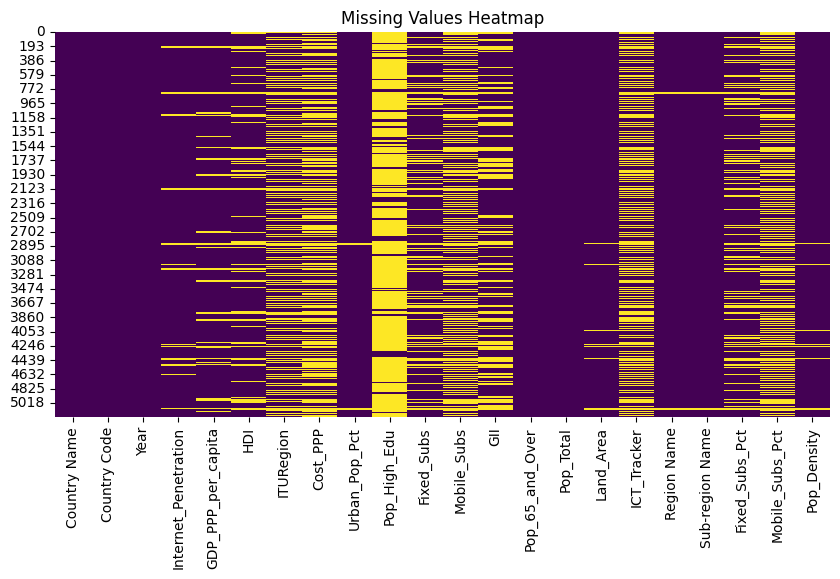

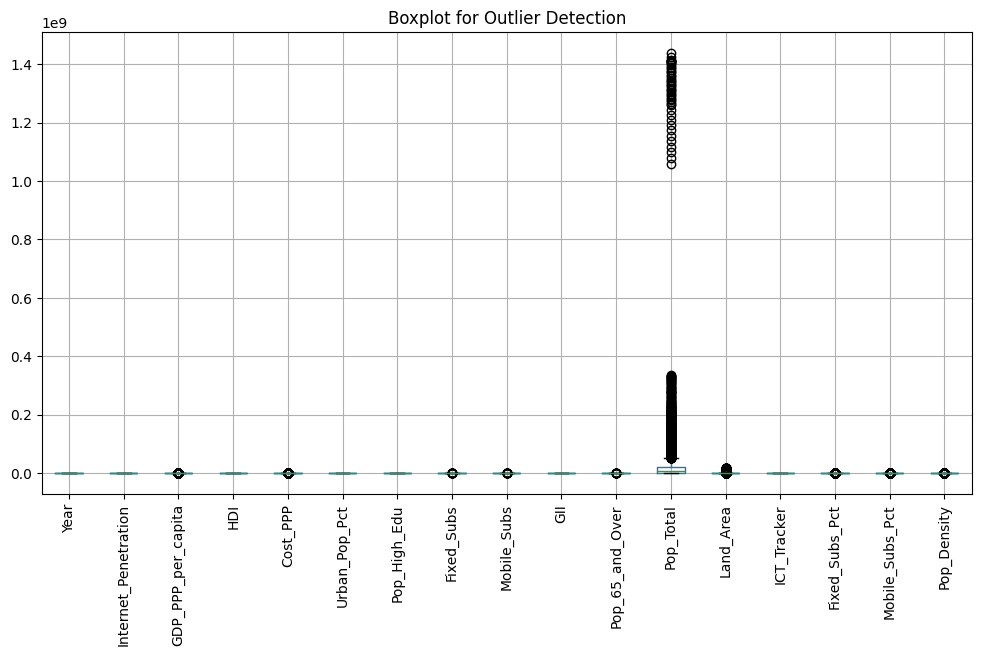

Outliers Count Per Column:
                  Column  Outlier Count
14        Fixed_Subs_Pct            703
12             Land_Area            608
11             Pop_Total            599
16           Pop_Density            505
15       Mobile_Subs_Pct            458
2     GDP_PPP_per_capita            220
4               Cost_PPP            200
8            Mobile_Subs             29
7             Fixed_Subs             26
10       Pop_65_and_Over             23
0                   Year              0
1   Internet_Penetration              0
3                    HDI              0
5          Urban_Pop_Pct              0
6           Pop_High_Edu              0
9                    GII              0
13           ICT_Tracker              0


In [25]:
# descriptive stats
print(internet_data.describe().T)

# missing values in each column
print("Missing Values:")
missing_values = internet_data.isnull().sum()
missing_percentage = (missing_values / len(internet_data)) * 100
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df = missing_df[missing_df["Missing Values"] > 0].sort_values(by="Missing Values", ascending=False)
print(missing_df)
# visualizing missing values
plt.figure(figsize=(10, 5))
sns.heatmap(internet_data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Using Boxplots to detect outliers in numerical columns
numeric_cols = internet_data.select_dtypes(include=["number"]).columns
plt.figure(figsize=(12, 6))
internet_data[numeric_cols].boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

# Finding outliers using the IQR method
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

outliers_dict = {col: detect_outliers_iqr(internet_data, col).shape[0] for col in numeric_cols}
outliers_df = pd.DataFrame(outliers_dict.items(), columns=["Column", "Outlier Count"])
outliers_df = outliers_df.sort_values(by="Outlier Count", ascending=False)
print("Outliers Count Per Column:")
print(outliers_df)

Creating a correlation matrix and identifying features strongly correlated with internet penetration (absolute correlation > 0.5).

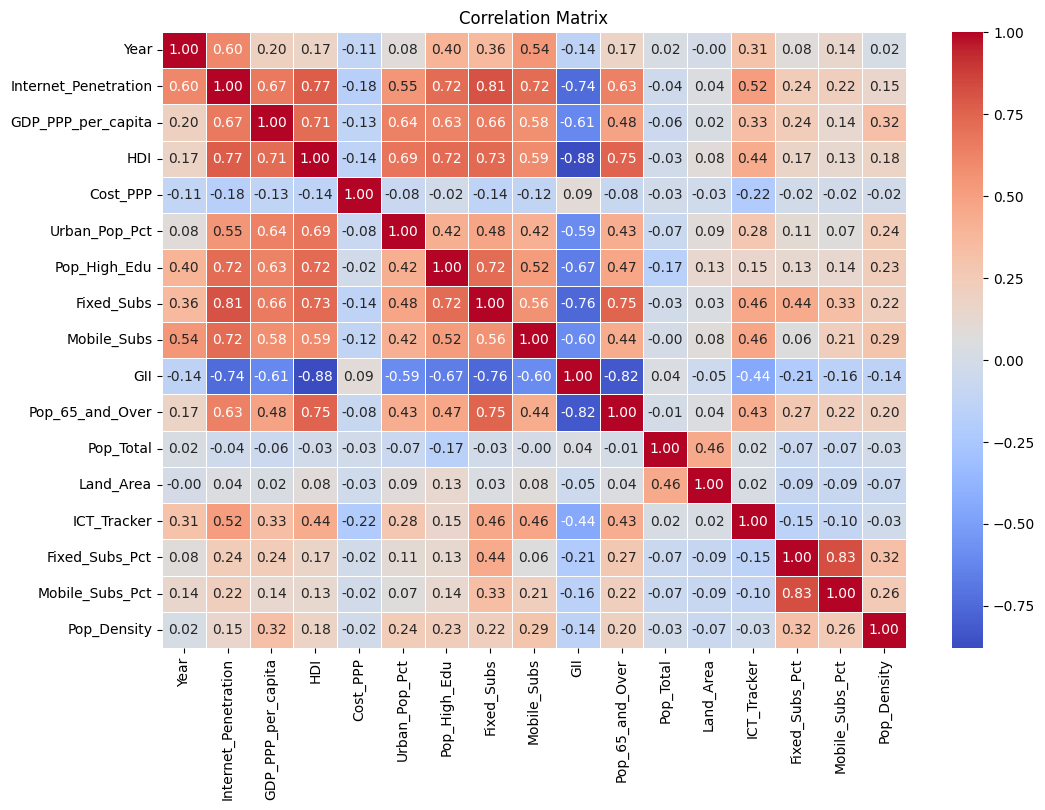

Strong Correlations (Above 0.5):
                    Internet_Penetration
Fixed_Subs                      0.814145
HDI                             0.772775
Mobile_Subs                     0.720110
Pop_High_Edu                    0.715632
GDP_PPP_per_capita              0.666537
Pop_65_and_Over                 0.633660
Year                            0.604873
Urban_Pop_Pct                   0.548043
ICT_Tracker                     0.515217
GII                            -0.742898


In [26]:
# Compute correlation matrix
corr_matrix = internet_data[numeric_cols].corr()

# Display correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Find the highest correlations (excluding self-correlation)
corr_filtered = corr_matrix.loc[((corr_matrix["Internet_Penetration"]>0.5) | (corr_matrix["Internet_Penetration"]<-0.5)) & (corr_matrix["Internet_Penetration"]!=1), ["Internet_Penetration"]].sort_values(by=["Internet_Penetration"], ascending=False)

print("Strong Correlations (Above 0.5):")
print(corr_filtered)

Saving data frame to file.

In [24]:
internet_data.to_csv("../data/internet_data_v5.csv", index=False)

End.